In [4]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# import nltk

In [5]:
dataset = pd.read_csv('Project_1_dataset_01_01_2022.csv', on_bad_lines='skip')
print(dataset)

      Unnamed: 0                                          full_text  \
0            590  Having made a massive impact in Saudi Arabia w...   
1            388  Cricket is all about the emotional rollercoast...   
2            423  New Zealand announces back-to-back tours next ...   
3            563  It's not the first time cricket fans in the co...   
4            634  An employee works on a computer terminal again...   
...          ...                                                ...   
2067        3546  DES MOINES, Iowa -- Drought conditions are exp...   
2068        3652  WASHINGTON — Vice President Kamala Harris is m...   
2069        3555  Drought conditions plaguing much of North Caro...   
2070        3507  LAKEWOOD, CO — Mild drought conditions hit Lak...   
2071        3611  An update to the U.S. drought monitor came out...   

                                                summary  \
0     Having made a massive impact in Saudi Arabia w...   
1     No matter which team fa

In [6]:
print(dataset.shape)

(2072, 9)


         0
0     1365
1     1797
2     2289
3     3823
4     4437
...    ...
2067   421
2068   647
2069  1799
2070   805
2071  1471

[2072 rows x 1 columns]


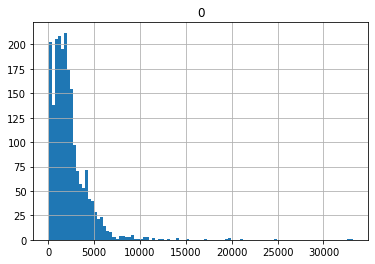

In [7]:
import matplotlib.pyplot as plt
hist_h = []

for index, row in dataset.iterrows():
    a = str(row['full_text'])
    n = 0
    for c in a:
        if c.isalpha() or c.isdigit():
            n = n+1
    hist_h.append(n)
pd.DataFrame(hist_h).hist(bins = 100)
print(pd.DataFrame(hist_h))

# Question 2

In [8]:
import random
np.random.seed(42)
random.seed(42)

from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset[["full_text","root_label"]], test_size=0.2)
print(np.array(train).shape)
print(np.array(test).shape)

(1657, 2)
(415, 2)


# Question 3

In [9]:
from sklearn.feature_extraction import text
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

for index, row in train.iterrows():
    row['full_text'] = clean(row['full_text'])

for index, row in test.iterrows():
    row['full_text'] = clean(row['full_text'])


In [10]:
import nltk

## Uncomment all and download and comment it back 
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords' )
# nltk.download('wordnet')
# nltk.download('omw-1.4')

from nltk import pos_tag
from sklearn.feature_extraction import text
from nltk.corpus import stopwords

stop_words_en = stopwords.words('english')
stop_words_skt = text.ENGLISH_STOP_WORDS
from string import punctuation
print("# of stop_words_en:\t\t %s" % len(stop_words_en))
print("# of stop_words_skt:\t\t %s" % len(stop_words_skt))
print("# of punctuation:\t\t %s" % len(punctuation))
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
wnl = nltk.wordnet.WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(list_word): 
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

def stem_rmv_punc(doc): # this should have been at the sentence-level because the pos-tag performs best at sentence-level
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

count_vect = CountVectorizer(stop_words='english', min_df=3, max_df=0.7, analyzer=stem_rmv_punc)

# of stop_words_en:		 179
# of stop_words_skt:		 318
# of punctuation:		 32


In [11]:
X_train_counts = count_vect.fit_transform(train.full_text)
print(X_train_counts.shape)

X_test_counts = count_vect.fit_transform(test.full_text)
print(X_test_counts.shape)

(1657, 10130)
(415, 4292)


In [21]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1657, 10130)
(415, 4292)


# Question 4

In [13]:
from sklearn.decomposition import NMF

modelNMF = NMF(n_components=50, init='random', random_state=0)
W_trainNMF = modelNMF.fit_transform(X_train_tfidf)
print(W_trainNMF.shape)

(1657, 50)


In [22]:
## For LSI
from sklearn.decomposition import TruncatedSVD
modelTruncatedSVD = TruncatedSVD(n_components=50, random_state=0)
W_trainTruncatedSVD = modelTruncatedSVD.fit_transform(X_train_tfidf)
print(W_trainTruncatedSVD.shape)

## LSI for Test Data
W_testTruncatedSVD = modelTruncatedSVD.fit_transform(X_test_tfidf)
print(W_testTruncatedSVD.shape)

(1657, 50)
(415, 50)


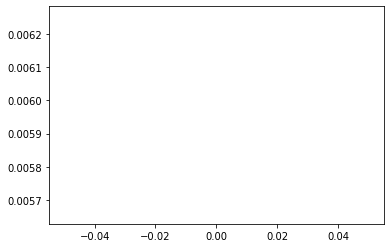

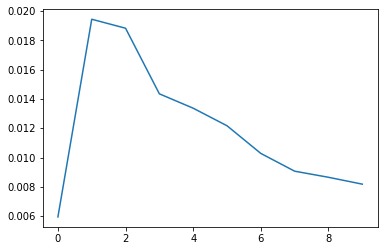

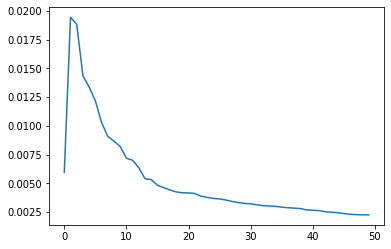

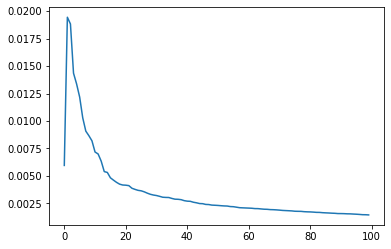

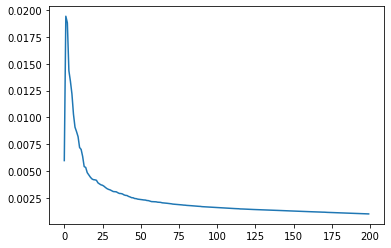

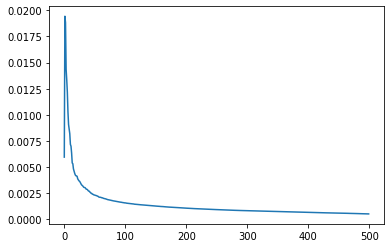

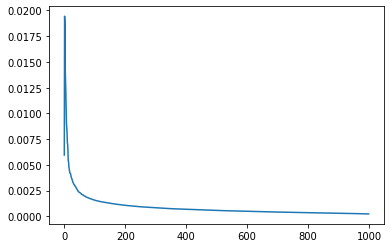

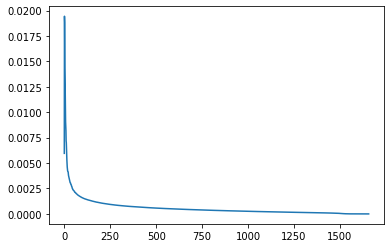

In [15]:
# print(modelTruncatedSVD.explained_variance_ratio_)
k = [1, 10, 50, 100, 200, 500, 1000, 2000]
for i in range(len(k)):
    SVD = TruncatedSVD(n_components=k[i], random_state=0)
    SVD.fit_transform(X_train_tfidf)
    fig = plt.plot(SVD.explained_variance_ratio_)
    plt.show()

# Question 6

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logistic = LogisticRegression(penalty = 'none', max_iter=10000, tol=0.1)
Xtrain_logistic = W_trainTruncatedSVD
ytrain_logistic = train.root_label=="sports"
logistic.fit(Xtrain_logistic, ytrain_logistic)

Xtest_logistic = W_testTruncatedSVD
ytest_logistic = test.root_label=="sports"
ytest_pred_logistic = logistic.predict(Xtest_logistic)
print(logistic.score(Xtest_logistic, ytest_logistic))
print(classification_report(ytest_logistic, ytest_pred_logistic))

0.7879518072289157
              precision    recall  f1-score   support

       False       0.74      0.88      0.81       206
        True       0.86      0.69      0.77       209

    accuracy                           0.79       415
   macro avg       0.80      0.79      0.79       415
weighted avg       0.80      0.79      0.79       415



In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    prob_score = pipe.predict_proba(test_data)

    fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
    return pipe

LogisticRegression(max_iter=10000, penalty='none', tol=0.1)

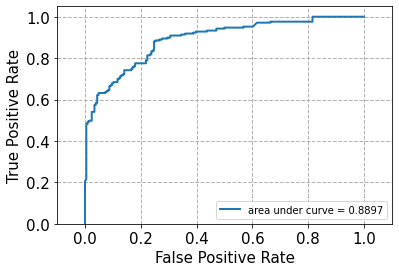

In [39]:
fit_predict_and_plot_roc(logistic, Xtrain_logistic, ytrain_logistic, Xtest_logistic, ytest_logistic)

In [40]:
# Regularization Comparision: none vs l1 vs l2

logisticNone = LogisticRegression(penalty = 'none', max_iter=10000, tol=0.1)
logisticL1 = LogisticRegression(penalty = 'l1', solver='liblinear', max_iter=10000, tol=0.1)
logisticL2 = LogisticRegression( penalty = 'l2', max_iter=10000, tol=0.1)

logisticNone.fit(Xtrain_logistic, ytrain_logistic)
logisticL1.fit(Xtrain_logistic, ytrain_logistic)
logisticL2.fit(Xtrain_logistic, ytrain_logistic)

ytest_pred_logistic_None = logisticNone.predict(Xtest_logistic)
print(logisticNone.score(Xtest_logistic, ytest_logistic))
print(classification_report(ytest_logistic, ytest_pred_logistic))

ytest_pred_logistic_L1 = logisticL1.predict(Xtest_logistic)
print(logisticL1.score(Xtest_logistic, ytest_logistic))
print(classification_report(ytest_logistic, ytest_pred_logistic))

ytest_pred_logistic_L2 = logisticL2.predict(Xtest_logistic)
print(logisticL2.score(Xtest_logistic, ytest_logistic))
print(classification_report(ytest_logistic, ytest_pred_logistic))

0.7879518072289157
              precision    recall  f1-score   support

       False       0.74      0.88      0.81       206
        True       0.86      0.69      0.77       209

    accuracy                           0.79       415
   macro avg       0.80      0.79      0.79       415
weighted avg       0.80      0.79      0.79       415

0.8819277108433735
              precision    recall  f1-score   support

       False       0.74      0.88      0.81       206
        True       0.86      0.69      0.77       209

    accuracy                           0.79       415
   macro avg       0.80      0.79      0.79       415
weighted avg       0.80      0.79      0.79       415

0.8746987951807229
              precision    recall  f1-score   support

       False       0.74      0.88      0.81       206
        True       0.86      0.69      0.77       209

    accuracy                           0.79       415
   macro avg       0.80      0.79      0.79       415
weighted avg     

In [42]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score

def classification_report_with_accuracy_score(y_true, y_pred):

    print (classification_report(y_true, y_pred))# print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

# 5-Fold Cross Validation with L1

cv_score_L1 = cross_val_score(logisticL1, X=Xtrain_logistic, y=ytrain_logistic, cv=5, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print (cv_score_L1)

              precision    recall  f1-score   support

       False       0.98      0.96      0.97       166
        True       0.96      0.98      0.97       166

    accuracy                           0.97       332
   macro avg       0.97      0.97      0.97       332
weighted avg       0.97      0.97      0.97       332

              precision    recall  f1-score   support

       False       0.97      0.93      0.95       166
        True       0.94      0.97      0.95       166

    accuracy                           0.95       332
   macro avg       0.95      0.95      0.95       332
weighted avg       0.95      0.95      0.95       332

              precision    recall  f1-score   support

       False       0.92      0.93      0.92       166
        True       0.93      0.92      0.92       165

    accuracy                           0.92       331
   macro avg       0.92      0.92      0.92       331
weighted avg       0.92      0.92      0.92       331

              preci

In [43]:
# 5-Fold Cross Validation with L2

cv_score_L2 = cross_val_score(logisticL2, X=Xtrain_logistic, y=ytrain_logistic, cv=5, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print (cv_score_L2)

              precision    recall  f1-score   support

       False       0.98      0.96      0.97       166
        True       0.96      0.98      0.97       166

    accuracy                           0.97       332
   macro avg       0.97      0.97      0.97       332
weighted avg       0.97      0.97      0.97       332

              precision    recall  f1-score   support

       False       0.97      0.92      0.94       166
        True       0.93      0.97      0.95       166

    accuracy                           0.95       332
   macro avg       0.95      0.95      0.95       332
weighted avg       0.95      0.95      0.95       332

              precision    recall  f1-score   support

       False       0.94      0.93      0.93       166
        True       0.93      0.94      0.93       165

    accuracy                           0.93       331
   macro avg       0.93      0.93      0.93       331
weighted avg       0.93      0.93      0.93       331

              preci

# Question 7

In [44]:
from sklearn.naive_bayes import GaussianNB

naivebayes = GaussianNB()
Xtrain = W_trainTruncatedSVD
ytrain = train.root_label=="sports"
logistic.fit(Xtrain, ytrain)

Xtest = W_testTruncatedSVD
ytest = test.root_label=="sports"
ytest_pred_gNB = logistic.predict(Xtest)
print(logistic.score(Xtest, ytest))
print(classification_report(ytest, ytest_pred_gNB))

0.7879518072289157
              precision    recall  f1-score   support

       False       0.74      0.88      0.81       206
        True       0.86      0.69      0.77       209

    accuracy                           0.79       415
   macro avg       0.80      0.79      0.79       415
weighted avg       0.80      0.79      0.79       415

